In [1]:
import matplotlib.pyplot as plt
import numpy as np

from commstools import SystemConfig, set_config, set_backend
from commstools.dsp.sequences import prbs
from commstools.dsp.waveforms import ook


In [2]:
set_backend("numpy")

config = SystemConfig(sampling_rate=1e6, samples_per_symbol=8)
set_config(config)

bits = np.concatenate(
    (
        prbs(500, seed=0x123456221, order=31),
        prbs(500, seed=0x123656221, order=31),
        prbs(500, seed=0x123658721, order=31),
        prbs(500, seed=0x123658938, order=31),
    )
)

sig_delta = ook(bits, pulse_shape="delta")
sig_rect = ook(bits, pulse_shape="rect")
sig_gauss = ook(bits, pulse_shape="gaussian", bt=0.2, span=10)
sig_rrc = ook(bits, pulse_shape="rrc", rolloff=0.1, span=10)

# fig, axs = plt.subplots(4, 1, figsize=(7, 10))

# sig_delta.plot_signal(ax=axs[0])
# axs[0].set_title("Delta")
# sig_rect.plot_signal(ax=axs[1])
# axs[1].set_title("Rectangular")
# sig_gauss.plot_signal(ax=axs[2])
# axs[2].set_title("Gaussian")
# sig_rrc.plot_signal(ax=axs[3])
# axs[3].set_title("RRC")

# plt.show()

# fig, axs = plt.subplots(4, 1, figsize=(7, 10))

# sig_delta.plot_psd(ax=axs[0])
# axs[0].set_title("Delta")
# sig_rect.plot_psd(ax=axs[1])
# axs[1].set_title("Rectangular")
# sig_gauss.plot_psd(ax=axs[2])
# axs[2].set_title("Gaussian")
# sig_rrc.plot_psd(ax=axs[3])
# axs[3].set_title("RRC")

# plt.show()


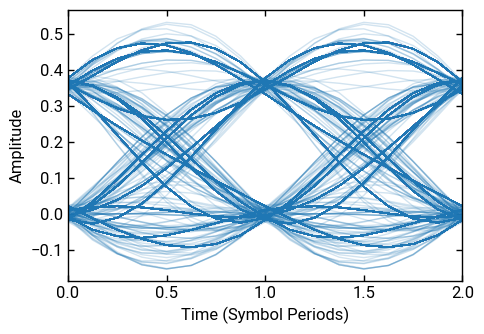

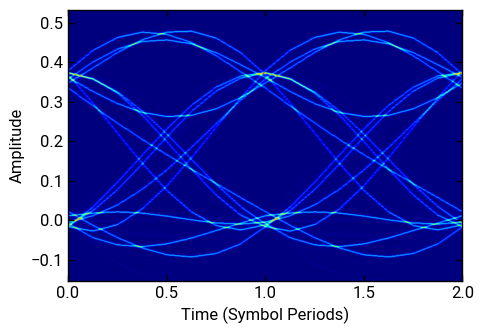

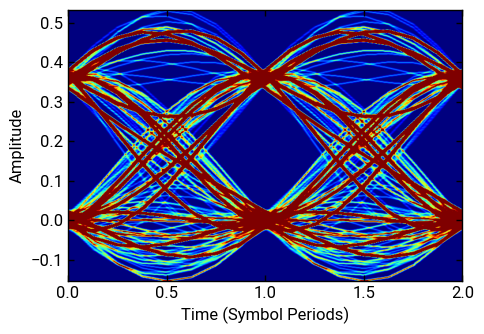

In [3]:
sig_rrc.plot_eye()
sig_rrc.plot_eye(plot_type="2d")
sig_rrc.plot_eye(plot_type="2d", vmax=0.01)
plt.show()


In [ ]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
b = [2, 2, 2]

a = np.array(a)

lll = []
ind = np.arange(0, 12, 2)
for i in ind:
    lll.append(a[i : i + 2])

print(lll)
print(np.stack(lll, axis=1))
print(np.stack(lll, axis=1).shape)


[array([1, 2]), array([3, 4]), array([5, 6]), array([7, 8]), array([ 9, 10]), array([11, 12])]
[[ 1  3  5  7  9 11]
 [ 2  4  6  8 10 12]]
(2, 6)


In [ ]:
samples = np.arange(1, 101)
indices = np.arange(len(samples) / 5)

l = []
for i in indices:
    start = int(i * 5)
    l.append(samples[start : start + 5])

print(l)
ls = np.stack(l, axis=1)
print(ls)


[array([1, 2, 3, 4, 5]), array([ 6,  7,  8,  9, 10]), array([11, 12, 13, 14, 15]), array([16, 17, 18, 19, 20]), array([21, 22, 23, 24, 25]), array([26, 27, 28, 29, 30]), array([31, 32, 33, 34, 35]), array([36, 37, 38, 39, 40]), array([41, 42, 43, 44, 45]), array([46, 47, 48, 49, 50]), array([51, 52, 53, 54, 55]), array([56, 57, 58, 59, 60]), array([61, 62, 63, 64, 65]), array([66, 67, 68, 69, 70]), array([71, 72, 73, 74, 75]), array([76, 77, 78, 79, 80]), array([81, 82, 83, 84, 85]), array([86, 87, 88, 89, 90]), array([91, 92, 93, 94, 95]), array([ 96,  97,  98,  99, 100])]
[[  1   6  11  16  21  26  31  36  41  46  51  56  61  66  71  76  81  86
   91  96]
 [  2   7  12  17  22  27  32  37  42  47  52  57  62  67  72  77  82  87
   92  97]
 [  3   8  13  18  23  28  33  38  43  48  53  58  63  68  73  78  83  88
   93  98]
 [  4   9  14  19  24  29  34  39  44  49  54  59  64  69  74  79  84  89
   94  99]
 [  5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90
   95

In [ ]:
ls.shape


(20, 5)

(5, 20)
(5,)


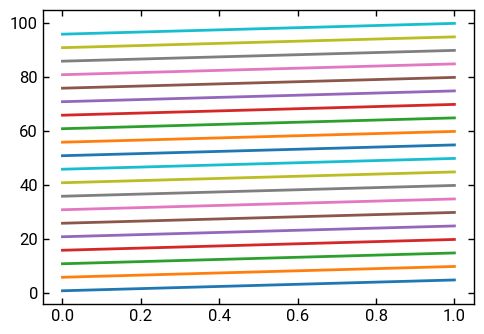

In [ ]:
x = np.linspace(0, 1, 5, endpoint=True)
# x = x.reshape(1, -1)

print(ls.shape)
print(x.shape)

plt.plot(x, ls)
